In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['TSLA','FB','AMZN','GOOG','TWTR']**

In [2]:
import yfinance as yf
stock_symbol = 'NVDA'
data = yf.download(tickers=stock_symbol,period='3y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
751,2022-04-20,225.169998,226.699997,212.000000,214.820007,214.820007,46897400
752,2022-04-21,217.089996,223.919998,200.000000,201.830002,201.830002,65620900
753,2022-04-22,203.029999,204.860001,195.000000,195.149994,195.149994,62356500
754,2022-04-25,192.020004,199.449997,190.960007,199.020004,199.020004,64156600
755,2022-04-26,197.179993,197.880005,186.699997,187.880005,187.880005,65109800


#### Visualizing the Real Stock Trend

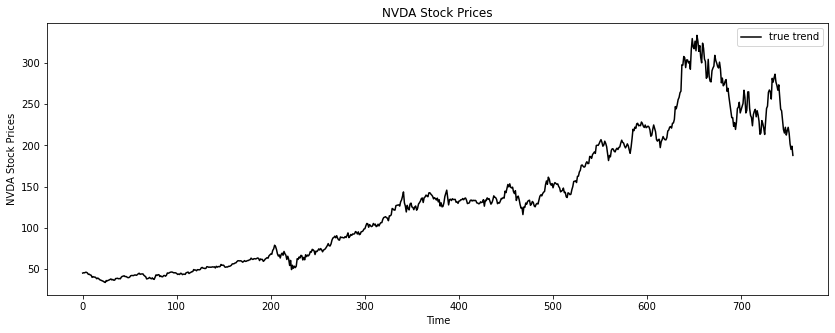

In [3]:
plt.figure(figsize=(14,5))
plt.plot(data['Close'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [4]:
test_size = 100
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((756, 7), (656, 7), (100, 7))

#### Preparing the training data

In [5]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,44.602501,45.112499,43.875000,44.832500,39192000
1,44.507500,45.507500,44.314999,45.250000,36292000
2,45.777500,46.202499,45.115002,45.117500,35428000
3,45.215000,46.217499,44.779999,45.797501,39468400
4,45.882500,45.982498,45.132500,45.752499,33682400


In [6]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.03527644, 0.03442779, 0.03734201, 0.03791852, 0.21528481])

In [7]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,3])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape

((556, 100, 5), (556,))

#### Preparaing testing data

In [8]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((200, 5),
            Open        High         Low       Close    Volume
 556  204.005005  204.612503  201.139999  202.500000  29070800
 557  203.577499  204.177505  197.527496  198.414993  38010000
 558  198.117493  198.470001  188.585007  189.662506  55056400
 559  190.304993  191.570007  180.729996  181.610001  68822400
 560  179.152496  190.419998  178.654999  187.797501  74906000)

In [9]:
df = scaler.transform(df)
df[0]

array([0.56451438, 0.54547786, 0.58490306, 0.56292558, 0.14118026])

In [10]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,3])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((100, 100, 5), (100,))

#### Defining the Scaling Label

In [11]:
# below is the scaling label, which will help inverse the transformation back to it's original values 
data_close = data.Close
data_close = data_close.values.reshape(-1, 1)
scaler_close = MinMaxScaler()
data_close_scaled = scaler_close.fit_transform(data_close)

In [12]:
y_test = y_test.reshape(-1,1)
y_test = scaler_close.inverse_transform(y_test)

#### GRU - Gated Recurrent Unit

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional

In [14]:
x_train.shape[1],x_train.shape[2]

(100, 5)

In [15]:
model = Sequential()

# Input layer
model.add(Bidirectional(LSTM(40,return_sequences=True),input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))

# 2nd layer (Hidden)
model.add(Bidirectional(LSTM(60,return_sequences=True)))
model.add(Dropout(0.2))

# 3rd layer (Hidden)
model.add(Bidirectional(LSTM(80)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 80)          14720     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 80)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 120)         67680     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100, 120)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 160)              128640    
 nal)                                                            
                                                        

In [16]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [17]:
def forecast():
    model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return y_pred

In [18]:
result_forecast = forecast()

Epoch 1/300
18/18 [==============================] - 12s 145ms/step - loss: 0.0198 - accuracy: 0.0018
Epoch 2/300
18/18 [==============================] - 2s 137ms/step - loss: 0.0059 - accuracy: 0.0018
Epoch 3/300
18/18 [==============================] - 3s 142ms/step - loss: 0.0042 - accuracy: 0.0018
Epoch 4/300
18/18 [==============================] - 2s 138ms/step - loss: 0.0035 - accuracy: 0.0018
Epoch 5/300
18/18 [==============================] - 3s 141ms/step - loss: 0.0032 - accuracy: 0.0018
Epoch 6/300
18/18 [==============================] - 3s 143ms/step - loss: 0.0029 - accuracy: 0.0018
Epoch 7/300
18/18 [==============================] - 3s 143ms/step - loss: 0.0029 - accuracy: 0.0018
Epoch 8/300
18/18 [==============================] - 3s 142ms/step - loss: 0.0029 - accuracy: 0.0018
Epoch 9/300
18/18 [==============================] - 2s 132ms/step - loss: 0.0037 - accuracy: 0.0018
Epoch 10/300
18/18 [==============================] - 3s 145ms/step - loss: 0.0032 - accur

#### Calculating the Accuracy using MAPE and RMSE

In [19]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100

mape_accuracy = calculate_accuracy(y_test, result_forecast)
mape_accuracy

80.26428870127226

#### Visualization

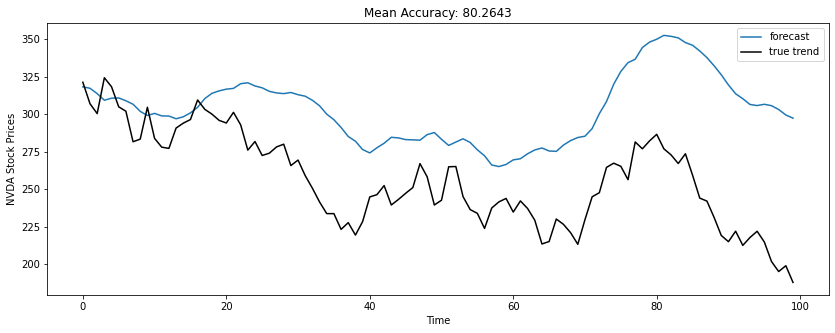

In [20]:
plt.figure(figsize=(14,5))
plt.plot(result_forecast,label='forecast')
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mape_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [21]:
import seaborn as sns
sns.set()

In [22]:
count = int(np.ceil(len(result_forecast) * 0.1))
signals = pd.DataFrame(index=range(test_size))
signals['signal'] = 0.0
signals['trend'] = result_forecast
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,318.199615,NaN,NaN
1,0.0,317.253052,NaN,NaN
2,0.0,313.679657,NaN,NaN
3,0.0,309.279205,NaN,NaN
4,0.0,310.633698,NaN,NaN
...,...,...,...,...
95,0.0,306.574097,345.898163,305.729645
96,1.0,305.655548,342.089172,305.729645
97,1.0,303.111969,337.679596,305.655548
98,1.0,299.442474,332.211121,303.111969


In [23]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [24]:
states_buy, states_sell, total_gains, invest = buy_stock(result_forecast, signals['signal'])

day 11: buy 1 units at price 298.830261, total balance 9701.169922
day 12: buy 1 units at price 298.747681, total balance 9402.421875
day 13: buy 1 units at price 296.941010, total balance 9105.480469
day 17, sell 1 units at price 310.372833, investment 4.523398 %, total balance 9415.853516,
day 18, sell 1 units at price 313.894043, investment 5.709226 %, total balance 9729.748047,
day 19, sell 1 units at price 315.526794, investment 6.259083 %, total balance 10045.274414,
day 20: cannot sell anything, inventory 0
day 21: cannot sell anything, inventory 0
day 22: cannot sell anything, inventory 0
day 23: cannot sell anything, inventory 0
day 28: buy 1 units at price 313.690796, total balance 9731.583984
day 30: buy 1 units at price 312.976074, total balance 9418.607422
day 31: buy 1 units at price 311.962646, total balance 9106.644531
day 32: buy 1 units at price 309.253387, total balance 8797.391602
day 33: buy 1 units at price 305.578064, total balance 8491.813477
day 34: buy 1 units

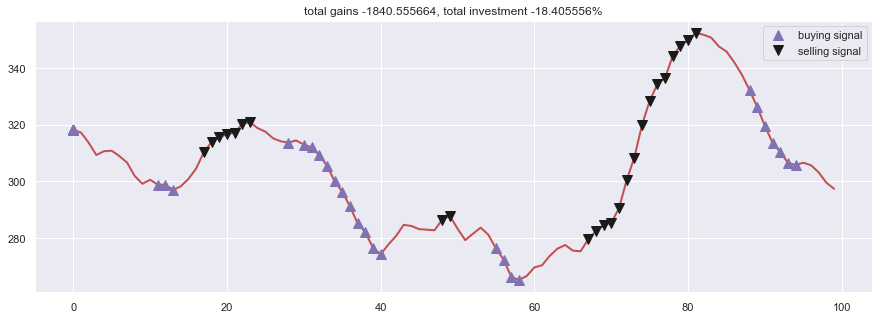

In [25]:
close =  result_forecast
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()